In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import replace_tag
from ic_course_utils import sphere
from ic_course_utils import plot_hits_voxelized

%matplotlib inline

In [2]:
input_file = "data/HEe_fastsim.beersheba.h5"
#input_file = "data/HEe_fullsim.beersheba.h5"

# Input file structure

The input file contains three tables:

- cDST (`CHITS/lowTh`): same as hDST, but contains a corrected-energy field and are associated to tracks. Equivalent to Esmeralda's highTh output.
- dDST (`DECO/Events`): a table containing the deconvolved hits
- kDST (`DST/Events`): copied from the input

The dDST table contains the following columns:
- event: event number
- npeak: index of the S2 peak within the event
- X, Y: x-y position of the deconvolved hit (center of the charge distribution bin)
- Z: center of the slice in z
- E: hit energy. Corresponds to E or Ec depending on the configuration
- Xpeak: global X position of the S2 peak
- Ypeak: global Y position of the S2 peak
- time: timestamp of the event in s
- nsipm: meaningless. Will be dropped in the future
- Xrms, Yrms: meaningless. Will be dropped in the future

In [3]:
!ptdump -v $input_file:/DECO/Events

/DECO/Events (Table(120229,)shuffle, zlib(4)) 'Deconvolved hits'
  description := {
  "event": Int32Col(shape=(), dflt=0, pos=0),
  "npeak": Float64Col(shape=(), dflt=0.0, pos=1),
  "X": Float64Col(shape=(), dflt=0.0, pos=2),
  "Y": Float64Col(shape=(), dflt=0.0, pos=3),
  "Z": Float64Col(shape=(), dflt=0.0, pos=4),
  "E": Float64Col(shape=(), dflt=0.0, pos=5),
  "Xpeak": Float64Col(shape=(), dflt=0.0, pos=6),
  "Ypeak": Float64Col(shape=(), dflt=0.0, pos=7),
  "time": Float64Col(shape=(), dflt=0.0, pos=8),
  "nsipm": Int64Col(shape=(), dflt=0, pos=9),
  "Xrms": Int64Col(shape=(), dflt=0, pos=10),
  "Yrms": Int64Col(shape=(), dflt=0, pos=11)}
  byteorder := 'little'
  chunkshape := (712,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshuffle, zlib(1)).is_csi=False}


# Input file data visualization

hDSTs are read directly as pandas DataFrames:

In [4]:
dhits = pd.read_hdf(input_file, "/DECO/Events")
dhits

,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
0,26,0.0,126.5,91.5,91.281375,0.000002,139.067634,87.195110,5.348394e+06,0,0,0
1,26,0.0,126.5,92.5,91.281375,0.000002,139.067634,87.195110,5.348394e+06,0,0,0
2,26,0.0,126.5,93.5,91.281375,0.000002,139.067634,87.195110,5.348394e+06,0,0,0
3,26,0.0,126.5,94.5,91.281375,0.000002,139.067634,87.195110,5.348394e+06,0,0,0
4,26,0.0,126.5,95.5,91.281375,0.000002,139.067634,87.195110,5.348394e+06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
120224,117,0.0,16.5,105.5,337.576844,0.000011,-3.181583,97.555456,1.812015e+07,0,0,0
120225,117,0.0,16.5,106.5,337.576844,0.000010,-3.181583,97.555456,1.812015e+07,0,0,0
120226,117,0.0,16.5,107.5,337.576844,0.000009,-3.181583,97.555456,1.812015e+07,0,0,0
120227,117,0.0,17.5,104.5,337.576844,0.000009,-3.181583,97.555456,1.812015e+07,0,0,0


dDSTs are read directly as DataFrames

<IPython.core.display.Javascript object>


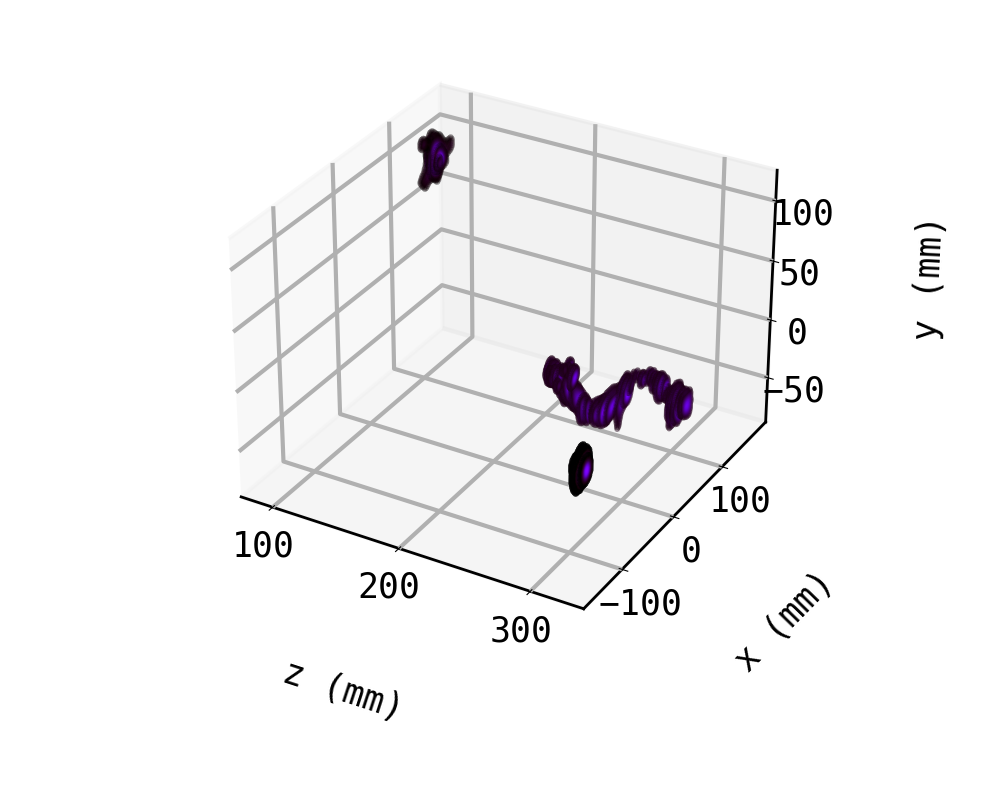

In [5]:
%matplotlib notebook
event = dhits.event.unique()[0]
hits  = dhits .loc[lambda df: (df.event == event)]

plt.ion()

ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
ax.scatter(hits.Z, hits.X, hits.Y, c=hits.E, s=0.1)
ax.set_xlabel("z (mm)", labelpad=50)
ax.set_ylabel("x (mm)", labelpad=50)
ax.set_zlabel("y (mm)", labelpad=50)
plt.show()

<IPython.core.display.Javascript object>


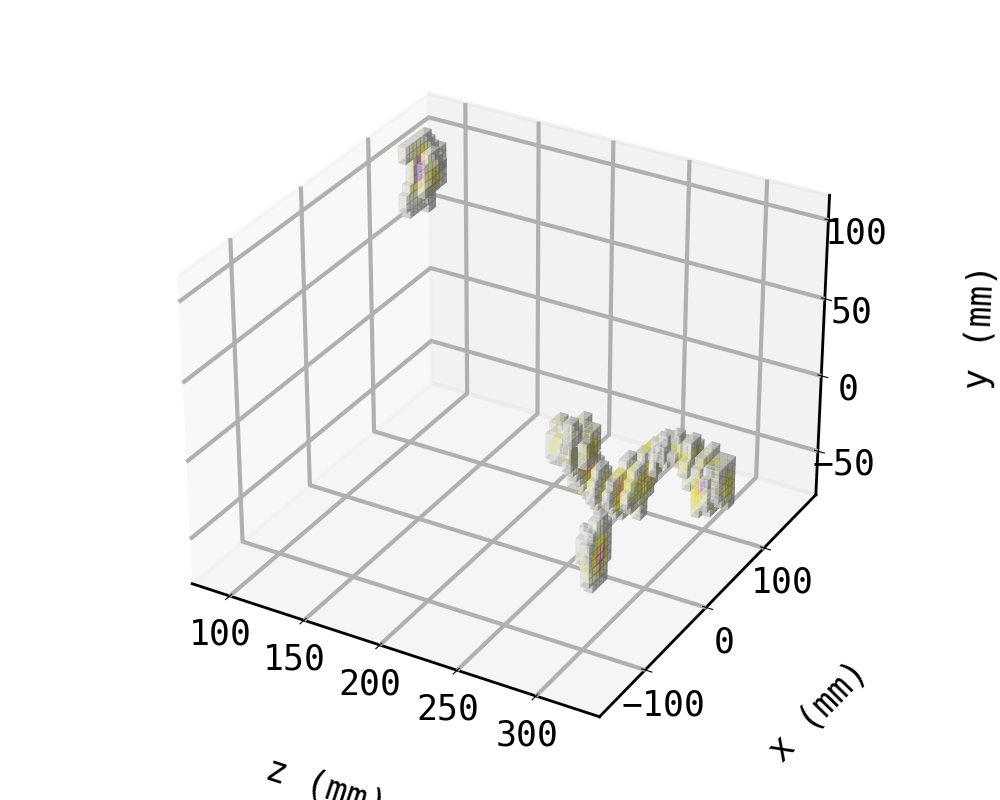

In [6]:
%matplotlib notebook
event = dhits.event.unique()[0]
hits  = dhits .loc[lambda df: (df.event == event)]
plot_hits_voxelized(hits)

# Isaura

## Description

Applies the track-finding algorithm (Paolina) to deconvolved hits.

This city reads dDSTs produced by Beersheba and produces tracks, a summary of the event topology and copies the kDST input. The output of this city is equivalent to that of Esmeralda.

The deconvolved hits are treated in the same way as the sipm hits in Esmeralda. The steps performed by Isaura are:
- Voxelizes the deconcolved hits
- Finds tracks by optimizing the path that connects all voxels
- Drops low energy voxels in the track extrema
- Obtains the blobs energy by integrating the energy is a certain radius around the end
- Produces a topology summary of the event

More details will be found in the official documentation:
https://next-exp-sw.readthedocs.io/en/latest/isaura.html
.

## Parameters

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `paolina_params` | `dict` | Parameters to configure the track-finding algorithm |

Paolina params:

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `vox_size` | `(float, float, float) ` | (Maximum) size of voxels |
| `strict_voxel_size` | `bool` | Whether to allow  event-wise adaptative voxel size |
| `energy_threshold` | `float` | Energy threshold for voxel-dropping at the extremes (in energy units, not pes) |
| `min_voxels` | `int` | Minimum number of voxels for for track reconstruction |
| `blob_radius` | `float` | Integration radius to obtain blob energies |
| `max_num_hits` | `int` | Maximum number of hits to attempt reconstruction (\*) |

(\*) Sometimes we record spurious events with an unphysical number of hits. These can make the program effectively hang, so we discard them for topological reconstruction.

## Configuration

An Isaura configuration file for NEW data.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [7]:
config_file = "config_files/isaura.conf"

In [8]:
!cat $config_file

event_range = all
compression = "ZLIB4"
print_mod   = 1

detector_db = "new"
run_number = -6400

paolina_params      = dict(
   vox_size         = [8 * mm, 8 * mm, 4 * mm], # big voxels for demonstration only
   strict_vox_size  = False,
   energy_threshold = 10 * keV,
   min_voxels       = 10,
   blob_radius      = 18 * mm,
   max_num_hits     = 100000) # might need a large number

## City execution

In [9]:
output_file = replace_tag(input_file, "beersheba", "isaura")
output_file

'data/HEe_fastsim.isaura.h5'

In [10]:
!city isaura $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector
events processed: 0, event number: 26
events processed: 1, event number: 39
events processed: 2, event number: 65
events processed: 3, event number: 78
events processed: 4, event number: 104
events processed: 5, event number: 117


## Output

- tracks (`Tracking/Tracks`): a table of track properties. Each row is a track in an event
- summary (`Summary/Events`): a table holding basic event properties
- dDST (`DECO/Events`): copied from input
- kDST (`DST/Events`): copied from input

The tracks table contains the following columns:
- event: event number
- trackID: track index
- energy: total track energy
- length: track length
- numb_of_voxels: number of voxels associated to the track
- numb_of_hits: number of hits associated to the track
- numb_of_tracks: number of tracks in the event
- x/y/z_min; max x/y/z coordinate in the hit collection of the track
- x/y/z_max: max x/y/z coordinate in the hit collection of the track
- x/y/z/r_ave: average x/y/z/r coordinate in the hit collection of the track
- extreme1_x/y/z: x/y/z coordinate of one extreme
- extreme2_x/y/z: x/y/z coordinate of the other extreme
- blob1_x/y/z: x/y/z coordinate of the lower energy blob
- blob2_x/y/z: x/y/z coordinate of the higher energy blob
- eblob1: energy of the lower energy blob
- eblob2: energy of the higher energy blob
- ovlp_blob_energy: whether the two blobs overlap, sharing part of the energy
- vox_size_x/y/z: voxel size along the x/y/z axis

The summary table contains the following columns:
- event: event number
- evt_energy: total event energy (including all tracks)
- evt_charge: total event charge (including all tracks)
- evt_ntrks: number of tracks in the event
- evt_nhits: number of hits in the event
- evt_x/y/z/r_avg: average x/y/z/r position of all hits
- evt_x/y/z/r_min: minimum x/y/z/r position of all hits
- evt_x/y/z/r_max: maximum x/y/z/r position of all hits
- evt_out_of_map: whether this events contains hits that could not be corrected properly


In [11]:
!ptdump -v $output_file:/Summary/Events
!ptdump -v $output_file:/Tracking/Tracks

/Summary/Events (Table(6,)shuffle, zlib(4)) 'Event summary information'
  description := {
  "event": Int32Col(shape=(), dflt=0, pos=0),
  "evt_energy": Float64Col(shape=(), dflt=0.0, pos=1),
  "evt_charge": Float64Col(shape=(), dflt=0.0, pos=2),
  "evt_ntrks": Int64Col(shape=(), dflt=0, pos=3),
  "evt_nhits": Int64Col(shape=(), dflt=0, pos=4),
  "evt_x_avg": Float64Col(shape=(), dflt=0.0, pos=5),
  "evt_y_avg": Float64Col(shape=(), dflt=0.0, pos=6),
  "evt_z_avg": Float64Col(shape=(), dflt=0.0, pos=7),
  "evt_r_avg": Float64Col(shape=(), dflt=0.0, pos=8),
  "evt_x_min": Float64Col(shape=(), dflt=0.0, pos=9),
  "evt_y_min": Float64Col(shape=(), dflt=0.0, pos=10),
  "evt_z_min": Float64Col(shape=(), dflt=0.0, pos=11),
  "evt_r_min": Float64Col(shape=(), dflt=0.0, pos=12),
  "evt_x_max": Float64Col(shape=(), dflt=0.0, pos=13),
  "evt_y_max": Float64Col(shape=(), dflt=0.0, pos=14),
  "evt_z_max": Float64Col(shape=(), dflt=0.0, pos=15),
  "evt_r_max": Float64Col(shape=(), dflt=0.0, pos=16)

Deconvolved hits and tracks are read directly as pandas DataFrames:

In [12]:
dhits   = pd.read_hdf(output_file, "/DECO/Events")
summary = pd.read_hdf(output_file, "/Summary/Events")
tracks  = pd.read_hdf(output_file, "/Tracking/Tracks")

tracks

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,26,0,0.619973,157.957540,264,14803,3,3.5,-75.5,236.003500,...,301.330533,6.640318,-1.648193,244.046353,0.168070,0.072833,0.000000,7.975000,7.791667,3.989109
1,26,1,0.182684,19.633275,9,1302,3,131.5,80.5,91.281375,...,96.633761,134.521355,99.372969,93.184689,0.178208,0.142462,0.137985,7.975000,7.791667,3.989109
2,26,2,0.060028,18.941137,8,1013,3,-140.5,-4.5,317.116250,...,320.052996,-128.504352,12.253144,320.167117,0.059469,0.055074,0.054515,7.975000,7.791667,3.989109
3,39,0,0.663956,133.584767,222,12889,4,-11.5,-22.5,112.142875,...,113.721474,9.046529,34.608210,189.611327,0.232229,0.020923,0.000000,7.583333,7.555556,3.941013
4,39,1,0.110620,32.259182,35,1918,4,19.5,-18.5,251.907938,...,269.103055,21.157929,-5.451183,259.869688,0.057142,0.049762,0.001030,7.583333,7.555556,3.941013
5,39,2,0.044274,16.403645,9,596,4,19.5,22.5,207.971375,...,209.372496,32.863067,25.112188,219.852937,0.044274,0.044209,0.044209,7.583333,7.555556,3.941013
6,39,3,0.010312,16.077175,8,365,4,35.5,11.5,231.935625,...,232.095843,45.578174,23.786476,237.810216,0.010312,0.010312,0.010312,7.583333,7.555556,3.941013
7,65,0,0.712389,92.104055,285,14860,3,-19.5,-38.5,308.991906,...,362.876832,27.644180,-34.947155,310.506246,0.067930,0.058157,0.000000,7.333333,7.571429,3.991290
8,65,1,0.072265,19.829993,17,1152,3,2.5,-29.5,274.891781,...,282.508237,4.203258,-9.277028,275.145178,0.061890,0.043594,0.033219,7.333333,7.571429,3.991290
9,65,2,0.003798,18.842396,8,197,3,10.5,-36.5,298.879250,...,298.879250,18.081424,-21.936521,300.883188,0.003798,0.003798,0.003798,7.333333,7.571429,3.991290


## Track visualization

<IPython.core.display.Javascript object>


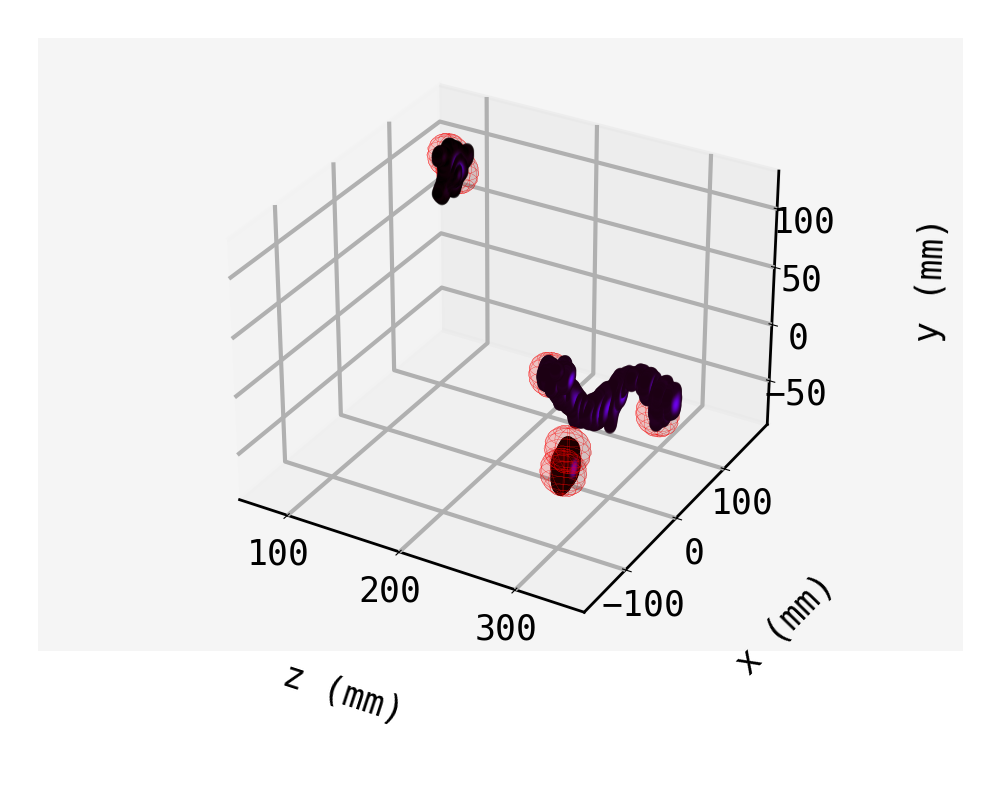

In [13]:
%matplotlib notebook
event = dhits.event.unique()[0]
rblob = 18 # mm
hits  = dhits .loc[lambda df: (df.event == event)]
trks  = tracks.loc[lambda df: (df.event == event)]

plt.ion()

ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
ax.scatter(hits.Z, hits.X, hits.Y, c=hits.Ec)
ax.set_facecolor("whitesmoke")
ax.set_xlabel("z (mm)", labelpad=50)
ax.set_ylabel("x (mm)", labelpad=50)
ax.set_zlabel("y (mm)", labelpad=50)
for _, trk in trks.iterrows():
    sphere(ax, trk.extreme1_z, trk.extreme1_x, trk.extreme1_y, rblob)
    sphere(ax, trk.extreme2_z, trk.extreme2_x, trk.extreme2_y, rblob)
plt.show()

<IPython.core.display.Javascript object>


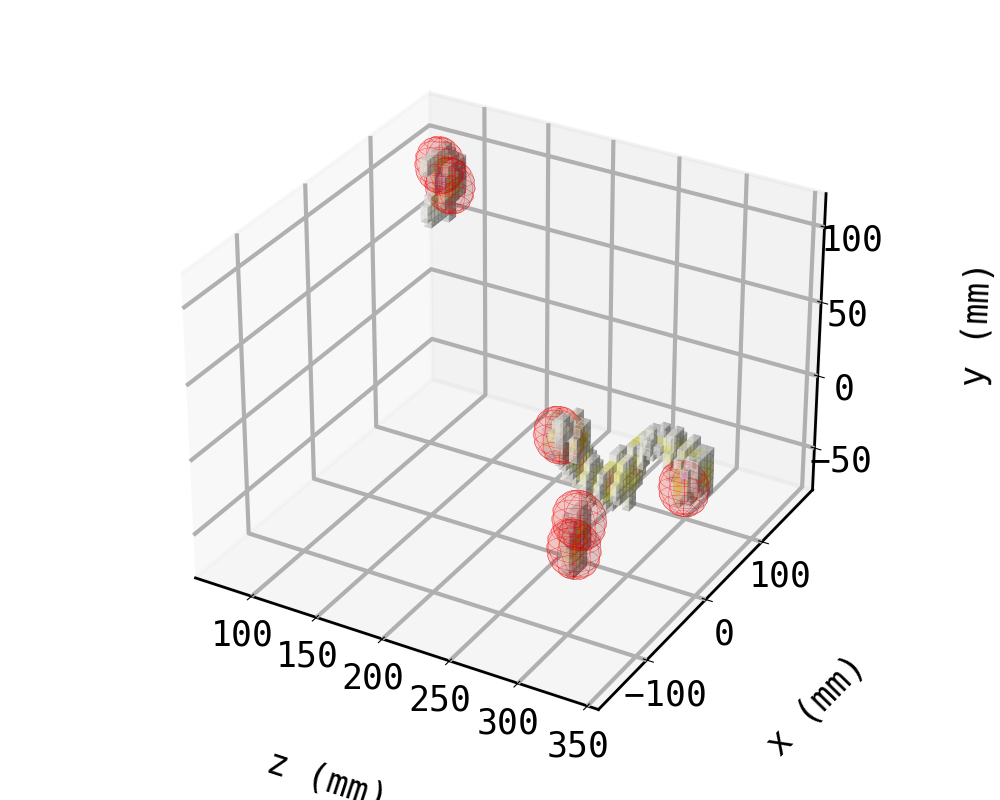

In [14]:
event = dhits.event.unique()[0]
hits  = dhits .loc[lambda df: (df.event == event)]
plot_hits_voxelized(hits)

for _, trk in trks.iterrows():
    sphere(plt.gca(), trk.extreme1_z, trk.extreme1_x, trk.extreme1_y, rblob)
    sphere(plt.gca(), trk.extreme2_z, trk.extreme2_x, trk.extreme2_y, rblob)


# Notes